In [1]:
import zipfile

import xml.etree.ElementTree as ET
import xml.dom.minidom

import chardet
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pylangacq

In [2]:
dataset_path = '/Users/sabijn/Documents/PhD/Datasets/CGN_2.0.3.zip'

### View specific file

In [3]:
file_to_read = "CGN_2.0.3/data/meta/info.txt"

with zipfile.ZipFile(dataset_path, 'r') as zf:
    with zf.open(file_to_read) as f:
        content = f.read().decode("latin-1")   # decode if it's text
        print(content)


  The directory /data/meta/ contains the meta data i.e. the information
  about the speakers and the recordings.

  The directory is organised as follows:

-------------------------------------------------------------------------

./text/            : meta data in TAB separated text files
./text/regioncodes/: contains files "countries.txt" (list of
                     country codes) and "zipcodes.txt" (list of
                     abbreviated postal codes)
./xls/             : meta data in Excel files
./xls/regioncodes/ : contains files "countries.xls" (list of
                     country codes) and "zipcodes.xls" (list of
                     abbreviated postal codes)
./imdi/            : meta data in the IMDI XML format (used by COREX)

See /doc_*/topics/metadata/ for more information

-------------------------------------------------------------------------

See http://www.tst.inl.nl/ for information and updates on the CGN.
Mail to tst-cgn@inl.nl with problems, questions, remarks

### Step through directories

In [4]:
import os

def list_dir_in_zip(zip_path, directory):
    directory = directory.rstrip("/") + "/"  # normalize
    with zipfile.ZipFile(zip_path, "r") as zf:
        files = set()
        dirs = set()
        for name in zf.namelist():
            if name.startswith(directory):
                relpath = name[len(directory):]
                if relpath and "/" not in relpath:
                    files.add(relpath)  # direct file
                elif relpath and "/" in relpath:
                    dirs.add(relpath.split("/", 1)[0])  # direct subdir
        return sorted(files), sorted(dirs)


# print(list_dir_in_zip(dataset_path, "CGN_2.0.3/data/annot/text/ort/comp-a/nl"))
print(list_dir_in_zip(dataset_path, "CGN_2.0.3/data/meta"))

(['info.txt'], ['imdi', 'text', 'xls'])


### Create sub zips

In [5]:
def copy_dirs_to_new_zip(src_zip, dst_zip, dirs_to_copy):
    with zipfile.ZipFile(src_zip, 'r') as zin:
        with zipfile.ZipFile(dst_zip, 'w') as zout:
            for item in zin.infolist():
                for d in dirs_to_copy:
                    d = d.rstrip("/") + "/"  # normalize
                    if item.filename.startswith(d):
                        buffer = zin.read(item.filename)
                        zout.writestr(item, buffer)

needed = False
if needed:
    # Example usage
    src_zip = '/Users/sabijn/Documents/PhD/Datasets/CGN_2.0.3.zip'
    dst_zip = '/Users/sabijn/Documents/PhD/Datasets/CGN_2.0.3_annot_lexicon.zip'
    dirs_to_copy = ["CGN_2.0.3/data/annot", "CGN_2.0.3/data/lexicon", "CGN_2.0.3/doc_Dutch/topics", "CGN_2.0.3/data/meta"]  # directories you want to copy

    copy_dirs_to_new_zip(src_zip, dst_zip, dirs_to_copy)
    print("Done! Created:", dst_zip)

## View and process data files (xml)

In [8]:
filename_xml = '/Users/sabijn/Documents/PhD/Datasets/CGN_2.0.3/data/annot/xml/tag/comp-a/nl/fn000248.tag'

tree = ET.parse(filename_xml)
root = tree.getroot()

xmlstr = ET.tostring(root, encoding="unicode")
dom = xml.dom.minidom.parseString(xmlstr)
print(dom.toprettyxml())

<?xml version="1.0" ?>
<ptext ref="fn000248">
	
  
	<pau ref="fn000248.1" s="N01002">
		
    
		<pw ref="fn000248.1.1" w="uhm" pos="TSW()" lem="uhm" wid="381784" lid="125606" nlid="125606#1" pq="man"/>
		
    
		<pw ref="fn000248.1.2" w="moeten" pos="WW(pv,tgw,mv)" lem="moeten" wid="192216" lid="63891" nlid="63891#1" pq="man"/>
		
    
		<pw ref="fn000248.1.3" w="langs" pos="VZ(init)" lem="langs" wid="620048" lid="135135" nlid="135135#1" pq="man"/>
		
    
		<pw ref="fn000248.1.4" w="uhm" pos="TSW()" lem="uhm" wid="381784" lid="125606" nlid="125606#1" pq="man"/>
		
    
		<pw ref="fn000248.1.5" w="de" pos="LID(bep,stan,rest)" lem="de" wid="619612" lid="134796" nlid="134796#1" pq="man"/>
		
    
		<pw ref="fn000248.1.6" w="Gamma" pos="N(eigen,ev,basis,zijd,stan)" lem="Gamma" wid="793206" lid="258813" nlid="258813#1" pq="man"/>
		
    
		<pw ref="fn000248.1.7" w="gaan" pos="WW(inf,vrij,zonder)" lem="gaan" wid="93182" lid="30559" nlid="30559#1" pq="man"/>
		
    
		<pw ref="fn000248.1.8" 

### Process speaker data

In [9]:
data_speakers = Path('/Users/sabijn/Documents/PhD/Datasets/CGN_2.0.3/data/meta/text/speakers.txt') # tab-seperated
output_dir = Path('/Users/sabijn/Documents/PhD/Datasets/CGN_additional_materials')
csv_speakers = output_dir / 'speakers.csv'

In [10]:
if csv_speakers.exists():
    print('Preprocessed file already exists, csv is loaded.')
    df = pd.read_csv(csv_speakers)
else:
    print('Preprocessed file does not exist and is created.')
    df = pd.read_csv(data_speakers, sep="\t")

    df['birthYear_cleaned'] = pd.to_numeric(df["birthYear"], errors="coerce").astype("Int64")
    df['exp_conducted'] = df['update'].str.split("/").str[-1]
    df['exp_conducted'] = pd.to_numeric(df['exp_conducted'], errors="coerce").astype("Int64")
    df['Age'] = df['exp_conducted'] - df['birthYear_cleaned']
    df.to_csv(csv_speakers)

Preprocessed file already exists, csv is loaded.


In [11]:
def plot_customized_histogram(data, binsize=30, figure_size=(8,6), title='Ages in CGN', xlabel='Age', ylabel='Frequency'):
    plt.figure(figsize=figure_size)
    plt.hist(data, bins=binsize, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.75)

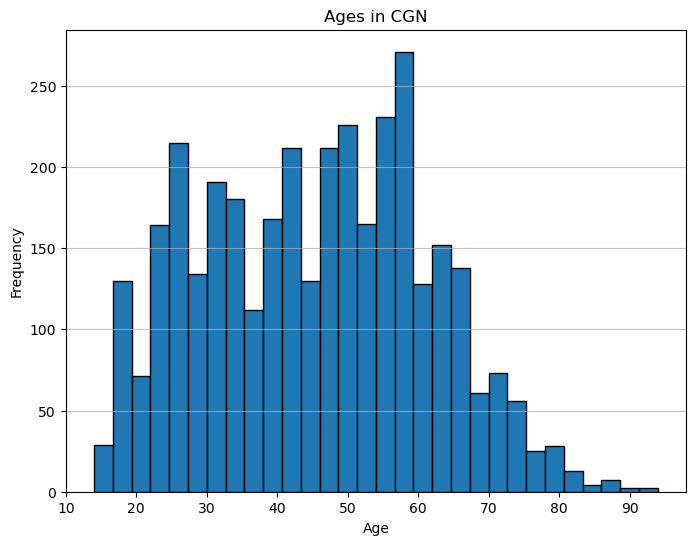

In [12]:
plot_customized_histogram(df['Age'])

In [13]:
df['Age'][df['Age'] < 12]

Series([], Name: Age, dtype: float64)

## Create CSV childes

In [14]:
childes = '/Users/sabijn/Documents/PhD/Datasets/CHILDES_Nicolopoulou/MP93/MP93_01kai_2.cha'

In [26]:
data = pylangacq.read_chat(childes)
print(data.participants())   # shows participants in the conversation
print(data.utterances())     # list of utterances


{'CHI'}
[Utterance(participant='CHI', tokens=[Token(word='I', pos='pron', mor='I-Prs-Nom-S1', gra=Gra(dep=1, head=2, rel='NSUBJ')), Token(word='go', pos='verb', mor='go-Fin-Ind-Pres-S1', gra=Gra(dep=2, head=4, rel='ROOT')), Token(word='to', pos='adp', mor='to', gra=Gra(dep=3, head=4, rel='CASE')), Token(word='bed', pos='noun', mor='bed', gra=Gra(dep=4, head=2, rel='OBL')), Token(word='.', pos='.', mor='', gra=Gra(dep=5, head=2, rel='PUNCT'))], time_marks=None, tiers={'CHI': 'I go to bed .', '%mor': 'pron|I-Prs-Nom-S1 verb|go-Fin-Ind-Pres-S1 adp|to noun|bed .', '%gra': '1|2|NSUBJ 2|4|ROOT 3|4|CASE 4|2|OBL 5|2|PUNCT'}), Utterance(participant='CHI', tokens=[Token(word='Joella', pos='propn', mor='Joella', gra=Gra(dep=1, head=2, rel='NSUBJ')), Token(word='tucks', pos='verb', mor='tuck-Fin-Ind-Pres-S3', gra=Gra(dep=2, head=4, rel='ROOT')), Token(word='me', pos='pron', mor='I-Prs-Acc-S1', gra=Gra(dep=3, head=2, rel='OBJ')), Token(word='in', pos='adp', mor='in', gra=Gra(dep=4, head=2, rel='COM

In [31]:
for utt in data.utterances():
    print(utt)

Utterance(participant='CHI', tokens=[Token(word='I', pos='pron', mor='I-Prs-Nom-S1', gra=Gra(dep=1, head=2, rel='NSUBJ')), Token(word='go', pos='verb', mor='go-Fin-Ind-Pres-S1', gra=Gra(dep=2, head=4, rel='ROOT')), Token(word='to', pos='adp', mor='to', gra=Gra(dep=3, head=4, rel='CASE')), Token(word='bed', pos='noun', mor='bed', gra=Gra(dep=4, head=2, rel='OBL')), Token(word='.', pos='.', mor='', gra=Gra(dep=5, head=2, rel='PUNCT'))], time_marks=None, tiers={'CHI': 'I go to bed .', '%mor': 'pron|I-Prs-Nom-S1 verb|go-Fin-Ind-Pres-S1 adp|to noun|bed .', '%gra': '1|2|NSUBJ 2|4|ROOT 3|4|CASE 4|2|OBL 5|2|PUNCT'})
Utterance(participant='CHI', tokens=[Token(word='Joella', pos='propn', mor='Joella', gra=Gra(dep=1, head=2, rel='NSUBJ')), Token(word='tucks', pos='verb', mor='tuck-Fin-Ind-Pres-S3', gra=Gra(dep=2, head=4, rel='ROOT')), Token(word='me', pos='pron', mor='I-Prs-Acc-S1', gra=Gra(dep=3, head=2, rel='OBJ')), Token(word='in', pos='adp', mor='in', gra=Gra(dep=4, head=2, rel='COMPOUND-PRT'